# Лабораторные работы 1-5 (Медведев К.В.)

# ЛР 1 (KNN)

## 1.1 Выбор начальных условий

Датасеты для задач классификации и регрессии, метрики моделей, а также обоснования их выбора приведены в `README.md` файле репозитория.

In [212]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, RobustScaler, PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from collections import Counter

### Задача классификации

#### Предобработка датасета `salary.csv`

In [191]:
salary_df = pd.read_csv('datasets/salary.csv')

salary_df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


Оценим число людей получающих более 50'000$ и менее, именно по этому признаку мы будем их классифицировать.

In [192]:
salary_df['salary'].value_counts()

salary
<=50K    24720
>50K      7841
Name: count, dtype: int64

О датасете заранее известно что пропущенные данные обозначены символом `?`. Заменим его на Nan и обработаем пустые значения.

In [193]:
salary_df.replace(' ?' , np.nan ,inplace=True)
salary_df.isna().sum()

age                  0
workclass         1836
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
salary               0
dtype: int64

Имеем пустые значения в колонках:
- `workclass` (тип занятости: частный сектор, государственная работа и тд.)
- `occupation` (профессия: продажи, административная должность, мэнеджеры и тд.)
- `native-country` (страна проихсождения)

Заменим `Nan` в этих колонках на `Other`, `Other`, `Other-service` соответственно.

In [194]:
salary_df[ 'workclass' ] = salary_df[ 'workclass' ].fillna('Other-service')
salary_df[ 'occupation' ] = salary_df[ 'occupation' ].fillna('Other')
salary_df[ 'native-country' ] = salary_df[ 'native-country' ].fillna('Other')

Явно отметим колонки с категориальными данными.

In [195]:
categoric_columns_salary = salary_df.select_dtypes(include=[ 'object' ]).columns
for column_name in categoric_columns_salary:
    print(column_name)

workclass
education
marital-status
occupation
relationship
race
sex
native-country
salary


Явно отметим колонки с числовыми данными

In [196]:
numeric_columns_salary = salary_df.select_dtypes(include=[ 'number' ]).columns
for column_name in numeric_columns_salary:
    print(column_name)

age
fnlwgt
education-num
capital-gain
capital-loss
hours-per-week


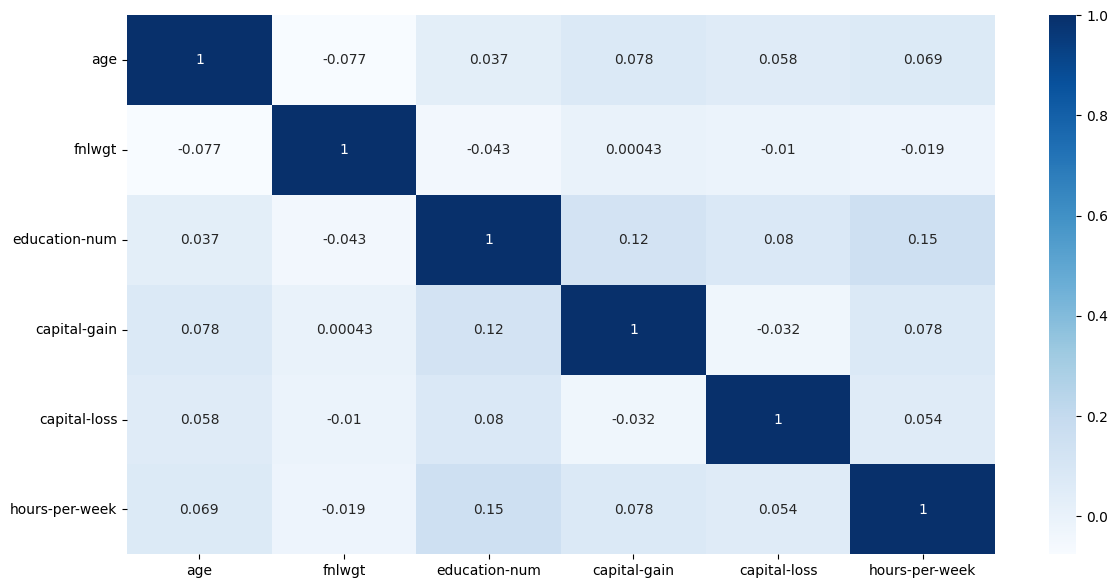

In [197]:
plt.figure(figsize = (14,7))
sns.heatmap(salary_df.select_dtypes(include=[ 'number' ]).corr() , annot=True , cmap = 'Blues')
plt.show()

Колонка `education-num` являет собой численную интерпретацию колокнки `education`, удалим вторую.

In [198]:
salary_df = salary_df.drop(columns=['education'])

categoric_columns_salary = categoric_columns_salary.tolist()
categoric_columns_salary.remove('education')
categoric_columns_salary = pd.Index(categoric_columns_salary)

Оценим категориальные переменные. И преобразуем их техникой `Label Encoding`, `One-Hot-Encoding`.

In [199]:
for column_name in categoric_columns_salary:
    print(salary_df[column_name].value_counts())
    print()

workclass
 Private             22696
 Self-emp-not-inc     2541
 Local-gov            2093
Other-service         1836
 State-gov            1298
 Self-emp-inc         1116
 Federal-gov           960
 Without-pay            14
 Never-worked            7
Name: count, dtype: int64

marital-status
Married-civ-spouse       14976
Never-married            10683
Divorced                  4443
Separated                 1025
Widowed                    993
Married-spouse-absent      418
Married-AF-spouse           23
Name: count, dtype: int64

occupation
 Prof-specialty       4140
 Craft-repair         4099
 Exec-managerial      4066
 Adm-clerical         3770
 Sales                3650
 Other-service        3295
 Machine-op-inspct    2002
Other                 1843
 Transport-moving     1597
 Handlers-cleaners    1370
 Farming-fishing       994
 Tech-support          928
 Protective-serv       649
 Priv-house-serv       149
 Armed-Forces            9
Name: count, dtype: int64

relationship
Husba

In [200]:
encoder = LabelEncoder()

def preprocess(df):
    # Remove duplicates
    df = df.drop_duplicates()

    # Label encoding for categorical features
    df['salary'] = encoder.fit_transform(df['salary'])
    df['sex'] = encoder.fit_transform(df['sex'])
    df['native-country'] = encoder.fit_transform(df['native-country'])
    df['marital-status'] = encoder.fit_transform(df['marital-status'])

    # Cleaning and transforming workclass
    df['workclass'] = df['workclass'].str.strip()
    allowed_workclass = ['Private', 'Self-emp-not-inc', 'Local-gov']
    df['workclass'] = df['workclass'].apply(lambda val: val if val in allowed_workclass else 'other')

    # One-hot encoding for workclass, race, and relationship
    df = pd.get_dummies(df, columns=['workclass'], drop_first=True, dtype=int)
    df = pd.get_dummies(df, columns=['race'], drop_first=True, dtype=int)
    df = pd.get_dummies(df, columns=['relationship'], drop_first=True, dtype=int)

    # Cleaning and encoding occupation
    df['occupation'] = df['occupation'].str.strip()
    mode_value = df['occupation'].mode()[0]
    df['occupation'] = df['occupation'].replace('?', mode_value)
    df['occupation'] = encoder.fit_transform(df['occupation'])

    return df

salary_df = preprocess(salary_df)

salary_df.head()

,age,fnlwgt,education-num,marital-status,occupation,sex,capital-gain,capital-loss,hours-per-week,native-country,...,workclass_other,race_ Asian-Pac-Islander,race_ Black,race_ Other,race_ White,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife
0,39,77516,13,4,0,1,2174,0,40,38,...,1,0,0,0,1,1,0,0,0,0
1,50,83311,13,2,3,1,0,0,13,38,...,0,0,0,0,1,0,0,0,0,0
2,38,215646,9,0,5,1,0,0,40,38,...,0,0,0,0,1,1,0,0,0,0
3,53,234721,7,2,5,1,0,0,40,38,...,0,0,1,0,0,0,0,0,0,0
4,28,338409,13,2,10,0,0,0,40,4,...,0,0,1,0,0,0,0,0,0,1


In [201]:
salary_df = salary_df.drop(['fnlwgt'], axis=1)

#### Бейзлайн

In [202]:
X = salary_df.drop('salary' , axis = 1).values
y = salary_df['salary'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3 , stratify=y, random_state=42)

In [203]:
knn_class = KNeighborsClassifier(n_neighbors=5)
knn_class.fit(X_train, y_train)

KNeighborsClassifier()

In [204]:
y_get = knn_class.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_get)}")
print(f"Precision: {precision_score(y_test, y_get)}")
print(f"Recall: {recall_score(y_test, y_get)}")
print(f"F1-score: {f1_score(y_test, y_get)}")

Accuracy: 0.842040565457898
Precision: 0.6866359447004609
Recall: 0.6335034013605442
F1-score: 0.659000442282176


#### Улучшенный бейзлайн

In [205]:
salary_df['net_capital_flow'] = salary_df['capital-gain'] - salary_df['capital-loss']

pt = PowerTransformer(method='yeo-johnson')
salary_df['age_normalized'] = pt.fit_transform(salary_df[['age']])

salary_df = salary_df.drop(['capital-gain', 'capital-loss', 'age'], axis=1)

X = salary_df.drop('salary' , axis = 1).values
y = salary_df['salary'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3 , stratify=y, random_state=42)

from imblearn.combine import SMOTEENN
smote_enn = SMOTEENN(random_state=3)
X_resampled_enn, y_resampled_enn = smote_enn.fit_resample(X, y)

X_train_enn, X_test_enn, y_train_enn, y_test_enn = train_test_split(X_resampled_enn, y_resampled_enn, test_size=0.3, random_state=42)

knn_class = KNeighborsClassifier(n_neighbors=8)
knn_class.fit(X_train_enn, y_train_enn)

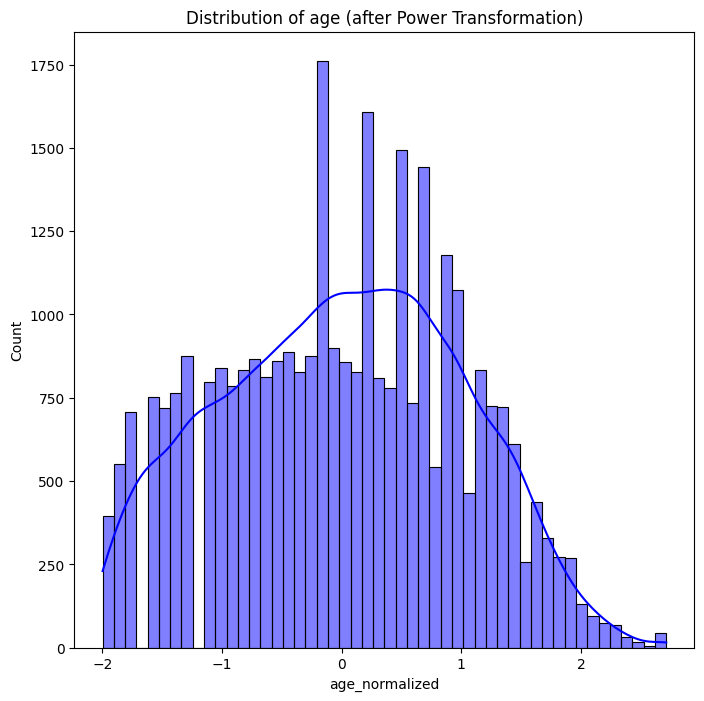

In [210]:
plt.figure(figsize=(8, 8))
sns.histplot(salary_df['age_normalized'], kde=True, color='blue', alpha=0.5)
plt.title("Distribution of age (after Power Transformation)")
plt.show()

In [208]:
y_get = knn_class.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_get)}")
print(f"Precision: {precision_score(y_test, y_get)}")
print(f"Recall: {recall_score(y_test, y_get)}")
print(f"F1-score: {f1_score(y_test, y_get)}")

Accuracy: 0.8191968858840402
Precision: 0.5805212620027435
Recall: 0.8996598639455783
F1-score: 0.7056861764215441


#### Самостоятельная имплементация

In [214]:
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))

class KNN:
    def __init__(self, k=3):
        self.k = k

    # Метод для расчета евклидова расстояния
    def euclidean_distance(self, point1, point2):
        return np.sqrt(np.sum((point1 - point2) ** 2))

    # Метод для подбора ближайших соседей
    def get_neighbors(self, X_train, X_test_point):
        distances = np.array([self.euclidean_distance(X_test_point, train_point) for train_point in X_train])
        sorted_idx = np.argsort(distances)
        return sorted_idx[:self.k]

    # Метод для обучения модели (не требуется для KNN, так как это ленивый алгоритм)
    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    # Метод для предсказания метки для одного тестового примера
    def predict_one(self, X_test_point):
        neighbors_idx = self.get_neighbors(self.X_train, X_test_point)
        neighbors_labels = self.y_train[neighbors_idx]
        most_common = Counter(neighbors_labels).most_common(1)
        return most_common[0][0]

    # Метод для предсказания всех тестовых данных
    def predict(self, X_test):
        return np.array([self.predict_one(test_point) for test_point in X_test])


knn = KNN(k=8)
knn.fit(X_train_enn, y_train_enn)

y_pred = knn.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
print(f"F1-score: {f1_score(y_test, y_pred)}")

Accuracy: 0.8155091169842246
Precision: 0.5731351207857712
Recall: 0.9179421768707483
F1-score: 0.7056708612518385
